query TNG database to quickly get data. based off https://www.tng-project.org/data/docs/api/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import h5py

import sys
sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
from functions import *

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |
      |                  TABLES Version 3.18.3                     |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |


In [26]:
TNG_file_highres = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2_highres.hdf5'

f = h5py.File(TNG_file_highres, 'r')
tng_cat_sh_id = np.array(f['catsh_id'])
tng_cat_group_id = np.array(f['catgrp_id'])
tng_cat_group_M200c = np.array(f['catgrp_Group_M_Crit200'])
f.close()

In [116]:
Illustris_file_highres = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_stellarmaps_orig_11.2_highres.hdf5'

f = h5py.File(Illustris_file_highres, 'r')
illustris_cat_sh_id = np.array(f['catsh_id'])
illustris_cat_group_id = np.array(f['catgrp_id'])
illustris_cat_group_M200c = np.array(f['catgrp_Group_M_Crit200'])
f.close()

In [6]:
from __future__ import division
import requests

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"e05ffb2ca14084c00423a3cd77f7e268"}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

In [7]:
r = get(baseUrl)

In [8]:
names = [sim['name'] for sim in r['simulations']]

In [9]:
i_tng = names.index('TNG100-1')
i_illustris = names.index('Illustris-1')

In [123]:
def check_ids(i, snap_n, h):
    
    r = get(baseUrl)
    sim = get( r['simulations'][i]['url'] )
    print(sim['name'])
    snaps = get( sim['snapshots'] )
    snap = get( snaps[snap_n]['url'] )

    mass_stars_min = 10**(11.2) / 1e10 * h
    
    #our sample
    search_query = "?mass_stars__gt="+ str(mass_stars_min)+ "&primary_flag=1"

    n_halos_list = []

    url = snap['subhalos'] + search_query
    subhalos = get(url)
    n_halos = subhalos['count']
    
    print(subhalos['next'])
    print(n_halos)
    ids=[]
    while subhalos['next'] != None:
        ids+=[subhalo['id'] for subhalo in subhalos['results']]
        subhalos = get(subhalos['next'])
    ids+=[subhalo['id'] for subhalo in subhalos['results']]
    ids.sort()
    print(len(ids))
    
    return ids
    

In [131]:
illustris_h = 0.704
tng_h = 0.6774

queried_tng_ids = check_ids(i_tng, 72, tng_h)
queried_illustris_ids = check_ids(i_illustris, 108-2, illustris_h)

TNG100-1
http://www.tng-project.org/api/TNG100-1/snapshots/72/subhalos/?limit=100&mass_stars__gt=10.7360664857&offset=100&primary_flag=1
235
235
Illustris-1
http://www.tng-project.org/api/Illustris-1/snapshots/108/subhalos/?limit=100&mass_stars__gt=11.1576480749&offset=100&primary_flag=1
339
339


## TNG 

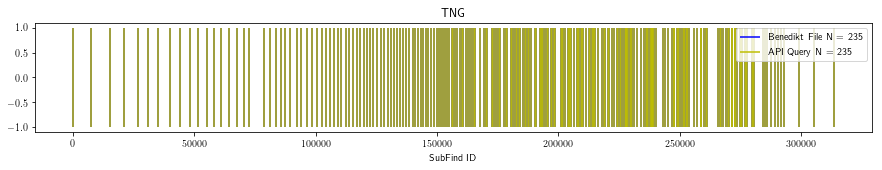

In [132]:
plt.figure(figsize=[15,2])
plt.vlines(tng_cat_sh_id, -1,1, color='b', alpha=1,
            label= ' Benedikt File N = {0}'.format(len(tng_cat_sh_id)))
plt.vlines(queried_tng_ids, -1,1, color='y', alpha=1,
            label= 'API Query N = {0}'.format(len(queried_tng_ids)))

plt.xlabel('SubFind ID')
plt.legend()

plt.title('TNG')

plt.show()

In [133]:
np.all([id in tng_cat_sh_id for id in queried_tng_ids])

True

In [134]:
missing_ids = list(set(queried_tng_ids).symmetric_difference(set(tng_cat_sh_id)))
print(missing_ids)

[]


## Illustris 

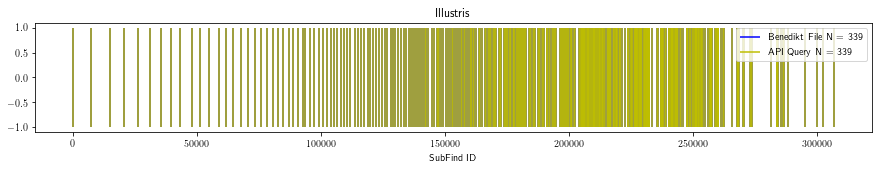

In [135]:
plt.figure(figsize=[15,2])
plt.vlines(illustris_cat_sh_id, -1,1, color='b', alpha=1,
            label= ' Benedikt File N = {0}'.format(len(illustris_cat_sh_id)))
plt.vlines(queried_illustris_ids, -1,1, color='y', alpha=1,
            label= 'API Query N = {0}'.format(len(queried_illustris_ids)))

plt.xlabel('SubFind ID')
plt.legend()

plt.title('Illustris')

plt.show()

In [136]:
np.all([id in illustris_cat_sh_id for id in queried_illustris_ids])

True

problem solved!! TNG was at wrong h (different from Illustris). Illustris was at wrong snapshot, 2 snapshotas are corrupted(snapshots 53 and 55) so the ordering is wrong with the index.